## **Домашняя работа 1.** (до 5 ноября)
Изучаем графовые *языковые модели*, построенные на основе совместной встречаемости слов. Это исследовательская работы, которая требует от вас как применения методов, которые мы изучали, так и качественного и количественного анализа результатов. Вы столкнетесь с вычислительными проблемами, если будете использовать методы, не думаю о том, какова их алгоритмическая сложность.  Далее будет описан примерный пул вопросов, на которые я ожидаю от вас ответов. Будьте уверены, ваша инициатива в исследовании будет оценена.    

### Анастасия Костяницына

In [7]:
import nltk
# nltk.download('brown')

In [1]:
import re

from typing import List
from collections import defaultdict, Counter

import random
import numpy as np
import networkx as nx

from nltk.corpus import brown, stopwords
import matplotlib.pyplot as plt

In [ ]:
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms import community

In [2]:
from nltk.stem import WordNetLemmatizer 
  
random.seed(34)
lemmatizer = WordNetLemmatizer() 
STOPS = stopwords.words('english')

In [50]:
class CoocuranceGraph:
    
    def __init__(self, directed=False):
        self.direc = directed
    
    @staticmethod
    def draw_graph(G, figsize=(8, 8), labels=True, layout=nx.spring_layout):
        pos = layout(G)
        plt.figure(figsize=figsize)
        nx.draw(G, pos, with_labels=labels)
        plt.show()
        
    def create_graph(self, adjlist):
        if self.direc: 
            base = nx.DiGraph()
        else: 
            base = nx.Graph()
        G = nx.parse_adjlist(adjlist, nodetype=str, create_using=base)
        return G 
    
    @staticmethod
    def largest_component(G):
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G_max = G.subgraph(Gcc[0])
        return G_max, Gcc
    
    @staticmethod
    def mean_path_length(G):
        all_paths = []
        for i in nx.shortest_path_length(G):
            all_paths += i[1].values()
        return np.mean(all_paths) 
    
    def basic_stats(self, G):
        ncc = nx.number_connected_components(G)
        print(f"N components: {ncc}")
        print(f"N nodes: {nx.number_of_nodes(G)}")
        print(f"N edges: {nx.number_of_edges(G)}")
        print(f"Density: {nx.density(G)}")
        print(f"Mean degree: {np.mean([i[1] for i in G.degree])}")
        if ncc == 1:
            print(f"Diameter: {nx.diameter(G)}")
            print(f"Mean path_length: {self.mean_path_length(G)}")

    # V2 ----------------------------------------------------------------------------
    # Версия, где на ходу формируется adjlist
    
    @staticmethod
    def add_in_edges(node, in_edges):
        for i in in_edges:
            if i != '':
                yield '{} {}'.format(i, node)
    
    @staticmethod
    def add_out_edges(node, out_edges):
        out_edges = [l for l in out_edges if l != '']
        if len(out_edges) > 1:
            yield '{} {}'.format(node, ' '.join(out_edges))
     
    @staticmethod
    def check_edges(edges):
        edges = [l for l in edges if l != '']
        return edges
    
    def make_edges(self, line, i, window, length):
        start = max(0, i - window)
        finish = min(length, i + window)
        in_edges = self.check_edges(line[start:i])
        out_edges = self.check_edges(line[i+1:finish+1])
        return in_edges, out_edges
        
    def pairs_generator2(self, line, window):
        length = len(line)-1
        for i in range(length):
            node = line[i]
            if node.startswith('VB'):
                in_edges, out_edges = self.make_edges(line, i, window, length)
                if len(out_edges) > 1:
                    yield '{} {}'.format(node, ' '.join(out_edges))
                for l in in_edges:
                    if l.startswith('N') and self.direc:
                        yield '{} {}'.format(l, node)
                    else:
                        yield '{} {}'.format(node, l)
    
    def create_adjlist2(self, sentences, window):
        adjlist = []
        for sent in sentences:
            for line in self.pairs_generator2(sent, window):
                adjlist.append(line)
        return adjlist
    
    def create_lm_coocurance2(self, sentences, window):
        if window > 7 or window < 1:
            raise ValueError('window_size should be from 1 to 7')
        adjlist = self.create_adjlist2(sentences, window)
        G = self.create_graph(adjlist)
        return adjlist, G
    

In [51]:
class TextPreprocesser:
    
    def __init__(self, lemmatization=False, preprocessing=False, select_pos=False):
        self.lemm = lemmatization
        self.preproc = preprocessing
        self.pos = select_pos
        
    @staticmethod
    def lemmtize(word):
        global lemmatizer
        return lemmatizer.lemmatize(word)
    
    @staticmethod
    def clean_word(word):
        global STOPS
        word = word.lower()
        if not word.isalpha():
            word = ''
        if word in STOPS:
            word = ''
        return word
    
    @staticmethod
    def select_pos(word):
        if word:
            pos = nltk.pos_tag([word])[0][1]
            if pos[:2] in ['NN', 'VB', 'RB',]: # 'IN']:
                word = pos + "_" + word
            else:
                word = ''
        return word
    
    def transform(self, word, s):
        if self.preproc:
            word = self.clean_word(word)
        if self.lemm:
            word = self.lemmtize(word)
        if self.pos:
            word = self.select_pos(word)
#         if word:
#             s.append(word)
        s.append(word)
        return s
        
    def preprocess(self, sentences):
        new_sentences = []
        for sent in sentences:
            s = []
            for word in sent:
                s = self.transform(word, s)
            new_sentences.append(s)
        return new_sentences
        
        

In [52]:
nltk.help.upenn_tagset("JJ")

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...


# Задание 1

* create indirected graph (0.5 points)
* create directed grpah (0.5 points)
* create function which can work with different window size (from 1 to 7) (1 point)

Поставим для себя задачу посмотреть сочетаемость глаголов. Возьмем для анализа 500 случайных предложений. Предварительно предобработаем их: удалим знаки препинания, стоп-слова, лемматизируем и оставим слова только определенных частей речи: существительные, глаголы и наречия. 

Граф формируется следующим образом: 

    Есть два типа вершин - глаголы (вершина конструкции) и зависимые (существительные и наречия). Формировать связи может только глагол. Будем дефолтно считать, что все, что перед глаголом и существительное - это подлежащее (направление in), все остальное - дополнения (или модификаторы в случае наречий)(направление out). Это +- работает, потому что корпус на английском языке. Однако есть определенная проблема в том, что в nltk не очень хороший pos tages и не очень хороший лемматизатор. По ходу формирования графа также были отсеяны вершины, у которых нет ни с кем связей из-за предобработки. Также удалили возможные петли. Хорошо, конечно, учитывать частотность связи, но пока без нее (по большей части потому, что нужно будет больше предложений тогда учитывать). 
    Понятно, что есть много разных других способов на это посмотреть, но в рамках задания пусть будет так. 

In [11]:
window = 2
brown_sent = list(brown.sents())

In [28]:
sentences50 = random.sample(brown_sent, 500)
TP = TextPreprocesser(lemmatization=True, preprocessing=True, select_pos=True)
clean_sentences50 = TP.preprocess(sentences50)

##### Без направления

In [53]:
CG1 = CoocuranceGraph(directed=False)
adjlist50_undir, G50_undir = CG1.create_lm_coocurance2(clean_sentences50, window)
G50_undir.remove_edges_from(nx.selfloop_edges(G50_undir))

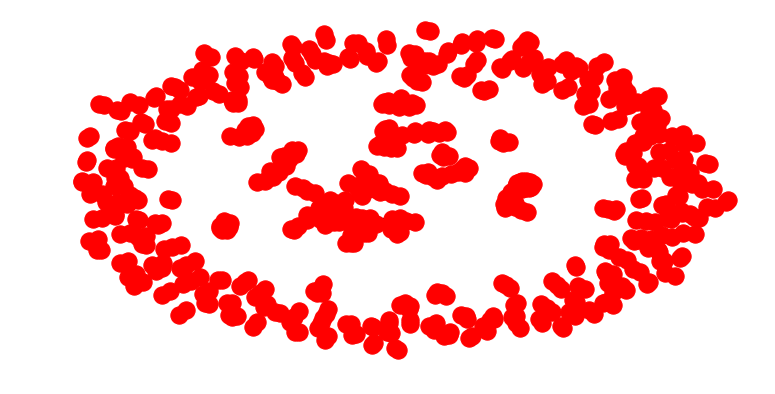

In [54]:
CG1.draw_graph(G50_undir, figsize=(10, 5), labels=False, layout=nx.spring_layout)

Определим наибольшую связную компонену и на ее основе выделим направленный граф.

In [55]:
G50_undir_lc, G50_undir_ccs = CG1.largest_component(G50_undir)

##### Направленный

In [56]:
def create_subgraph(G50_dir, G50_undir_ccs):
    verbs = [i for i in G50_undir_ccs[0] if i.startswith('V')]
    not_verbs = [i for i in G50_undir_ccs[0] if not i.startswith('V')]
    sub_G = nx.DiGraph()
    for verb in verbs:
        for not_verb in not_verbs:
            for n in nx.all_simple_paths(G50_dir, source=verb, target=not_verb):
                nx.add_path(sub_G, n)
            for n in nx.all_simple_paths(G50_dir, source=not_verb, target=verb):
                nx.add_path(sub_G, n)
    return sub_G

Построим направленный граф из наибольшей связной компоненты

In [57]:
CG0 = CoocuranceGraph(directed=True)
adjlist50_dir, G50_dir = CG0.create_lm_coocurance2(clean_sentences50, window)
G50_dir.remove_edges_from(nx.selfloop_edges(G50_dir))

In [58]:
G50_dir_lc = create_subgraph(G50_dir, G50_undir_ccs)

проверочка

In [59]:
G50_dir_lc.number_of_edges(), G50_undir_lc.number_of_edges()

(60, 61)

In [60]:
G50_dir_lc.number_of_nodes(), G50_undir_lc.number_of_nodes()

(60, 60)

Нарисуем граф

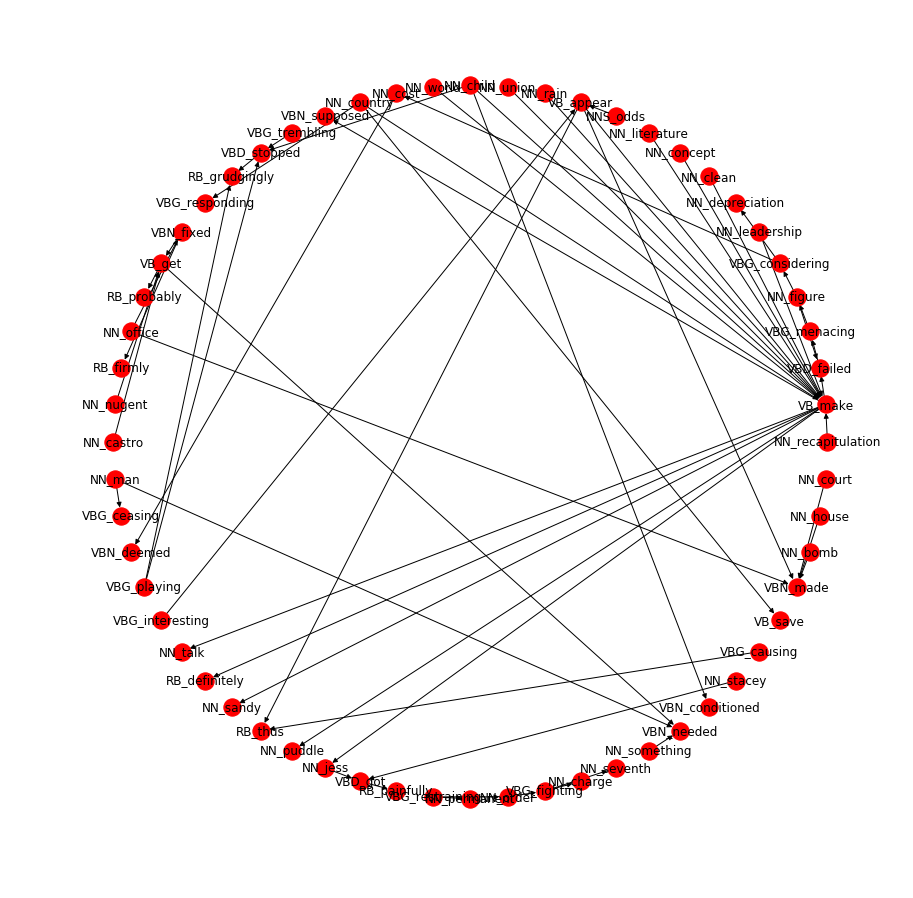

In [61]:
CG1.draw_graph(G50_dir_lc, figsize=(12, 12), labels=True, layout=nx.circular_layout)

# Задание 2

* Посмотрите сколько компонент, вершин, ребер.
* Плотность. 
* Средняя степень вершины в графе. (2 points)

In [62]:
print("Undirected, all", "\n")
CG1.basic_stats(G50_undir)

Undirected, all 

N components: 204
N nodes: 648
N edges: 448
Density: 0.002137119087144847
Mean degree: 1.382716049382716


In [63]:
print("Undirected, largest comp.", "\n")
CG1.basic_stats(G50_undir_lc)

Undirected, largest comp. 

N components: 1
N nodes: 60
N edges: 61
Density: 0.03446327683615819
Mean degree: 2.033333333333333
Diameter: 13
Mean path_length: 4.848888888888889


Видно, что граф разряженый, в нем много компонент. Так как  в итоге получилось не очень много примеров, скорее всего выделились глаголы и существительные, которые встретились совсем редко, однако возможно, что могли попасться и не очень частотные словосочетания в принципе. 

Нарисуем ненаправленный граф с нашей наибольшей компонентой

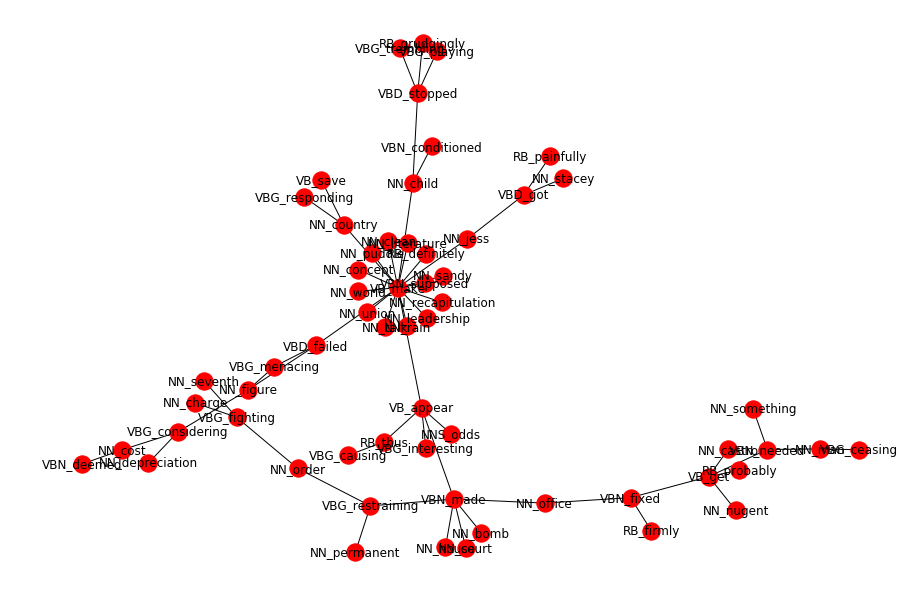

In [64]:
CG1.draw_graph(G50_undir_lc, figsize=(12, 8), labels=True, layout=nx.spring_layout)

# Задание 3

* Расcчитайте распределние степеней вершин внутри графа и постройте график (1 point)
* Сделайте log-log scale для этих значений (1 point) 
* Проверьте, если здесь powerlaw distribution (1 point) (то есть постройте апроксимирующую прямую) Дайте анализ результам у четом того, что ваш граф не является scale-free network 

тут есть пример - https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree_histogram.html 

\+ Посмотрим как меняется  распределение степеней с увеличением числа предложений. 

In [65]:
def degree_distribution(degrees, probability=False):
    degreeCount = Counter(degrees)
    x, y = zip(*degreeCount.items())
    if probability:
        y = np.divide(y, np.sum(y))
    return x, y

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
---------
5
Mean degree: 1.5
Mean path_length: 1.25
Pref. attachment path: 4.24417928851698
---------
100
Mean degree: 1.6
Mean path_length: 1.44
Pref. attachment path: 3.3819891953681287
---------
500
Mean degree: 1.8666666666666667
Mean path_length: 2.648888888888889
Pref. attachment path: 2.718301205940163
---------
1000
Mean degree: 2.0745341614906834
Mean path_length: 8.335905250569036
Pref. attachment path: 3.293231424207987
---------
2000
Mean degree: 2.23921568627451
Mean path_length: 8.049544405997693
Pref. attachment path: 3.5791948207195228


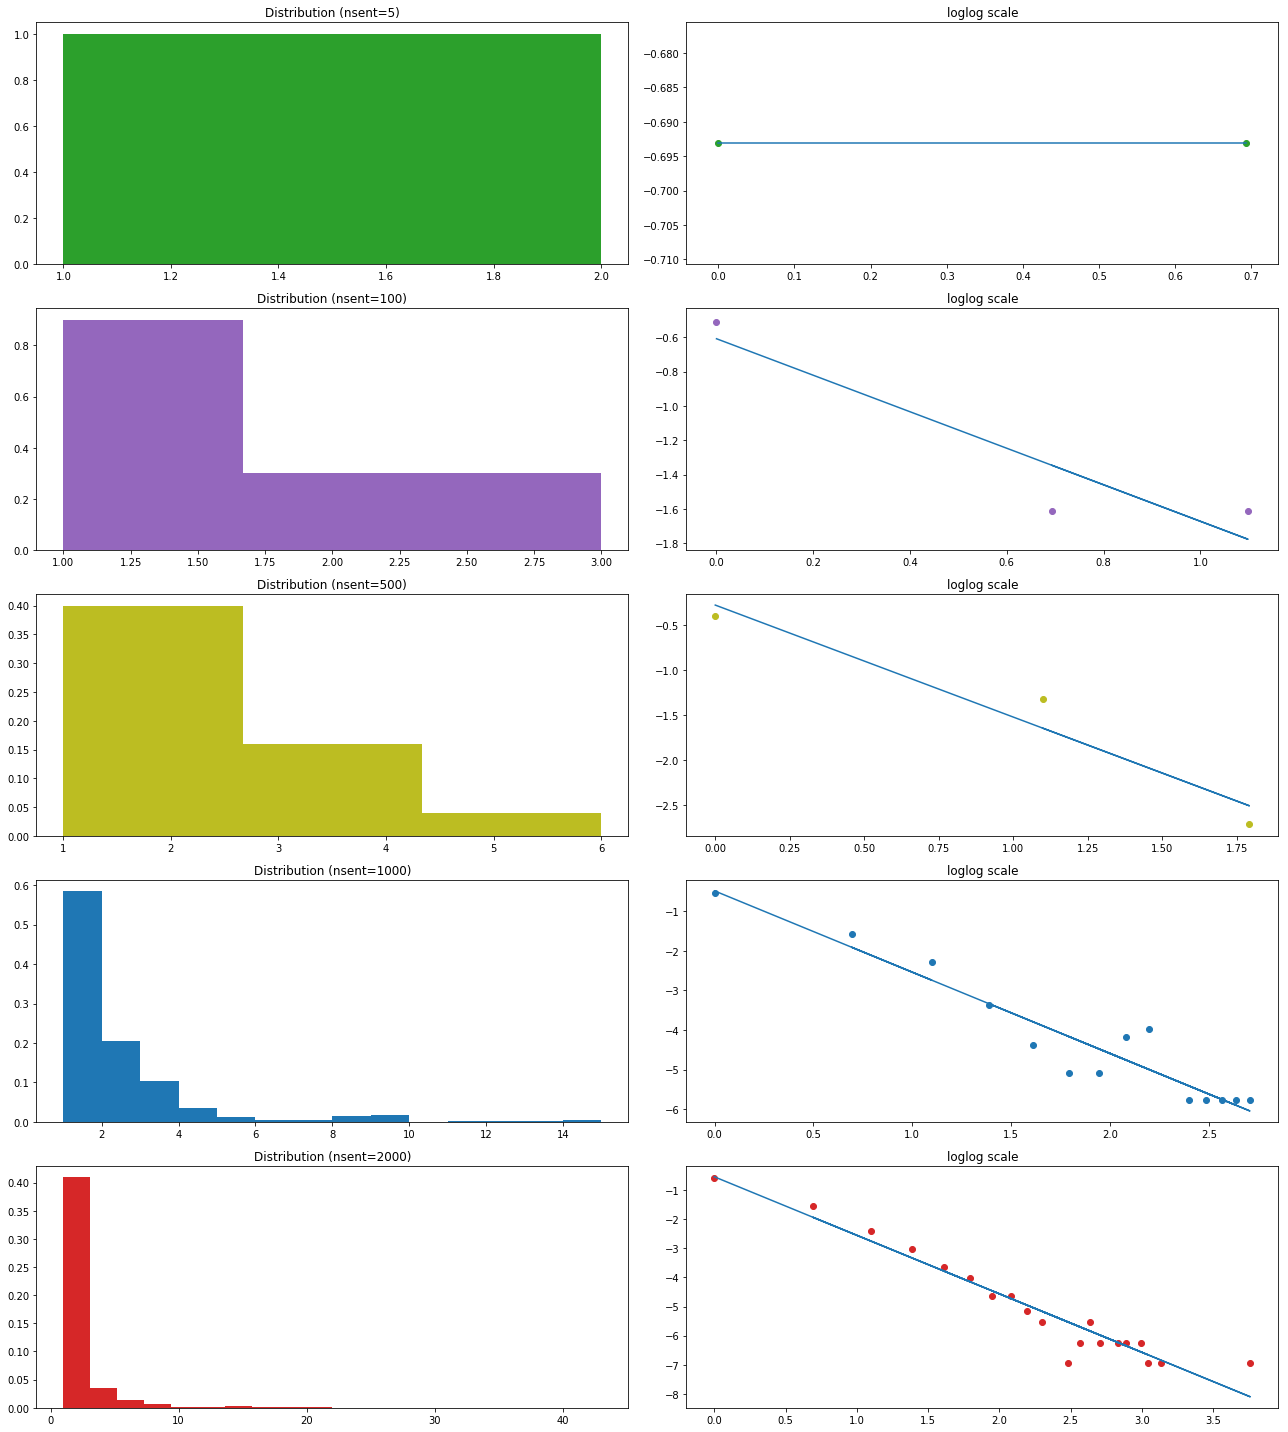

In [42]:
%time
nsent = (5, 100, 500, 1000, 2000)
colors = ("C2", "C4", "C8", "C0", "C3")
fig, axes = plt.subplots(ncols=2, nrows=len(nsent), figsize=(18, 20))

for index, ns in enumerate(nsent):
    sentences = random.sample(brown_sent, ns)
    sentences = TP.preprocess(sentences)
    adjlist, G = CG1.create_lm_coocurance2(sentences, 2)
    
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])

    degrees = [i[1] for i in G.degree]
    x_prob, y_prob = degree_distribution(degrees, probability=True)
    
    log_x = np.log(x_prob)
    log_y = np.log(y_prob)
    m, b = np.polyfit(log_x, log_y, 1)
    
    print('---------')
    print(ns)
    print(f"Mean degree: {np.mean(degrees)}")
    print(f"Mean path_length: {CG1.mean_path_length(G)}")
    print(f"Pref. attachment path: {np.log(len(G.nodes))/np.log(np.log(len(G.nodes)))}")
    
    axes[index, 0].hist(degrees, bins = len(x_prob), color=colors[index], density=True)
    axes[index, 0].set_title('Distribution (nsent={})'.format(ns))
    
    axes[index, 1].scatter(log_x, log_y, color=colors[index])
    axes[index, 1].plot(log_x, m*log_x + b)
    axes[index, 1].set_title('loglog scale')
    

plt.tight_layout()
plt.show()

Видно, что с увеличением числа предложений (и слов), распределение степеней вершин в наибольшей компоненьте все больше напоминает степенное распределение. Также наблюдается увеличение среднего пути, что может говорить о том, что у нас не образовываются новые хабы, а усложняются существующие. Кажется, что в этом случае должен работать принцип preferential attachment, так как глаголы с более размытой семантикой (которые ожидаемо должны выделяться с помощью центральностей), имеют большую сочетаемость и при увеличении контектов должны формировать все больше связей. Однако средние длины путей не сходятся. 

# Задание 4

Используйте ваши знания о центральностях и об их применимости к тем или иным типам графов. Рассчитайте их (возможно на сабграфе), сделайте отображение графа, на котором размер вершины будет зависить от показателя центральности, ну или цветом, как здесь: https://networkx.org/documentation/stable/auto_examples/drawing/plot_random_geometric_graph.html#sphx-glr-auto-examples-drawing-plot-random-geometric-graph-py (3 points)

## Degree_centrality

Посчитем degree centrality на выходящих ребрах. Ожидаем, что в результате должны выделиться двуместные глаголы (т.е. глаголы, у которых в модели управления есть дополнения) и существительные, которые выступают у нас подлежащим.

In [82]:
def centrality(func, G, node_size_inc=5000, figsize=(12, 8), labels=True):
    degree_centrs = func(G)
    node_sizes = [degree_centrs[n]*node_size_inc for n in G.nodes()]
    unique_degrees = sorted(list(set(degree_centrs.values())))
    node_colours = [unique_degrees.index(c) for c in degree_centrs.values()]
    
    plt.figure(figsize=(12, 8))
    nx.draw_spring(G, with_labels=labels,
                  node_size = node_sizes,
                  node_color = node_colours, cmap = plt.cm.Blues)
    plt.show()
    return degree_centrs

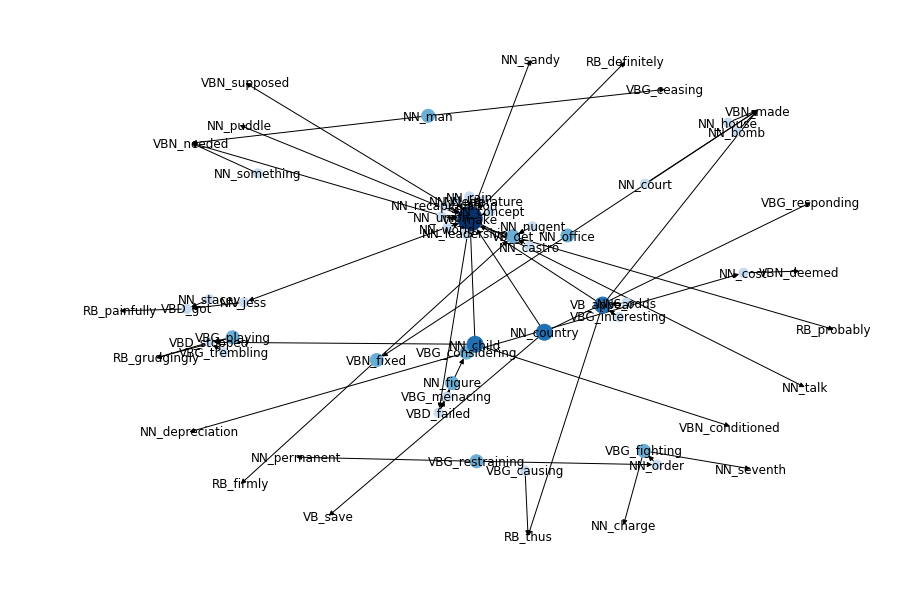

In [75]:
degree_centrs = centrality(nx.out_degree_centrality, G50_dir_lc, node_size_inc=5000, figsize=(26, 15))

Гипотеза подтвердилась. В топе узлов наибольшей центральностью встретились глаголы: make, appear, fixed и get. Форма considering, конечно, спорная. 

## Eigenvector_centrality

Еще можно расчитать eigenvector_centrality на неправленной версии графа. Ожидаем, что в результате должны выделиться глаголы с наибольшей сочетаемостью и отсящиеся к ним дополнения и подлежащие.

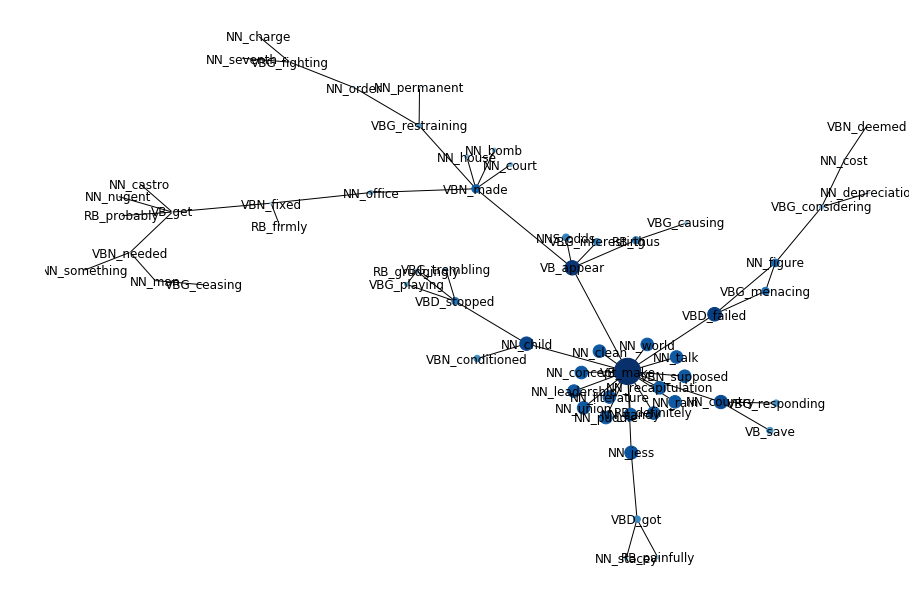

In [94]:
eigen_centrs = centrality(nx.eigenvector_centrality, G50_undir_lc, node_size_inc=1000, figsize=(26, 15))

In [95]:
sorted(eigen_centrs.items(), key=lambda x: x[1], reverse=True)[:10]

[('VB_make', 0.6876067515863272),
 ('VB_appear', 0.20763578217782144),
 ('VBD_failed', 0.18529799705487865),
 ('NN_child', 0.18003312175167166),
 ('NN_country', 0.17749369589304848),
 ('NN_jess', 0.16864790930370097),
 ('NN_recapitulation', 0.15860637835885505),
 ('VBN_supposed', 0.15860637835885505),
 ('NN_leadership', 0.15860637835885505),
 ('NN_talk', 0.15860637835885505)]

Гипотеза подтвердилась. 

# Задание 5

Ваша задача: применить методы поиска сообществ и попытаться интерпретировать выдачу (3 points)

## girvan_newman

In [105]:
comp = girvan_newman(G50_undir_lc)
res = {i:words for i, words in enumerate(tuple(sorted(c) for c in next(comp)))}

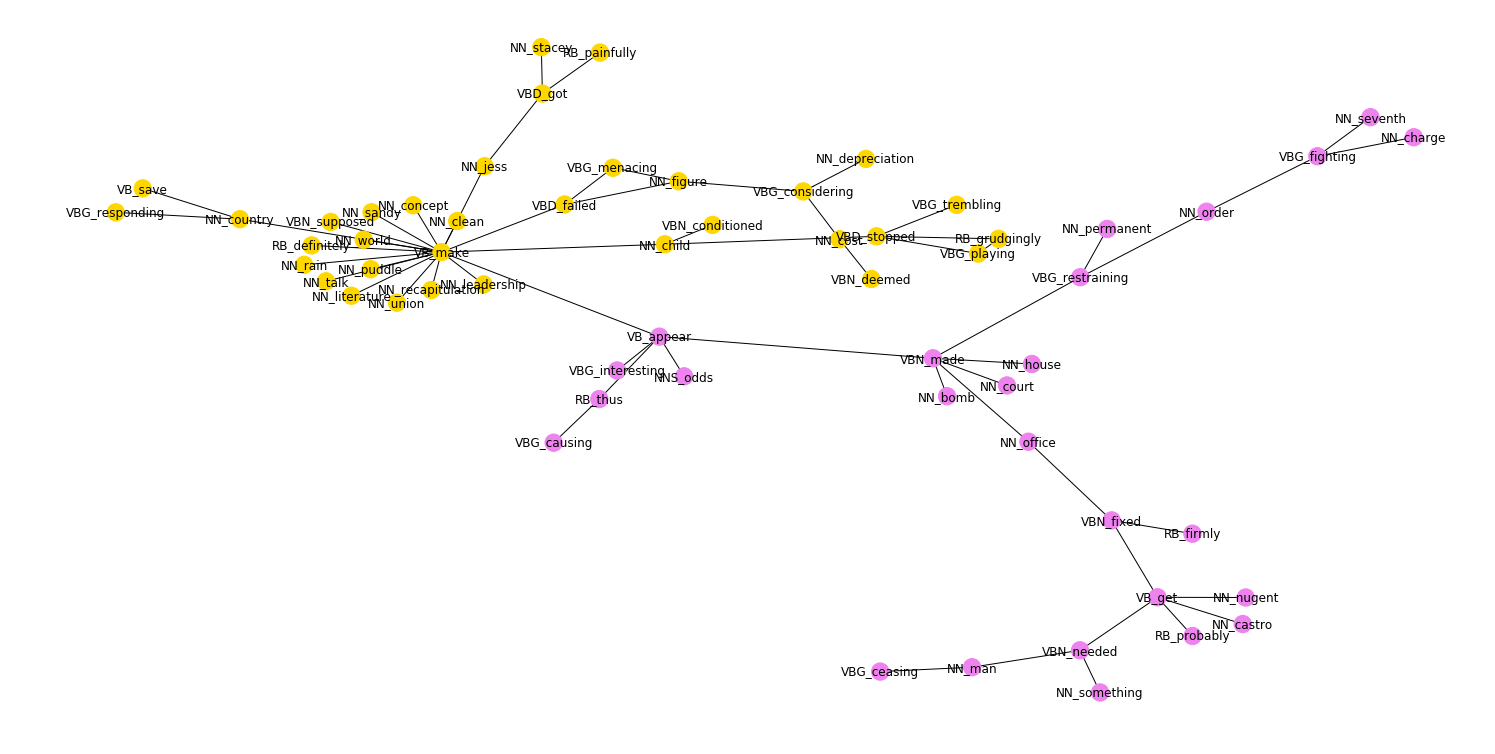

In [106]:
subset_color = ["gold", "violet", "limegreen", "darkorange"]
color = []

for v in G50_undir_lc.nodes():
    for i, words in res.items():
        if v in words:
            color.append(subset_color[i])

plt.figure(figsize=(20, 10))
nx.draw(G50_undir_lc, nx.spring_layout(G50_undir_lc),
        node_color=color, with_labels=True)
plt.show()

In [172]:
community.modularity(G50_undir_lc, res.values())

0.4701693093254464

Алгоритм Гирван — Ньюмена поделил ненаправленную версию графа на две части так, что все, что проходит через глаголо make попало в один кластер, а с глаголом appear в другой. Это объясняется тем, что алгоритм использует edge_betweenness_centrality, а ребро между этими двумя глаголами единственное связующее звено между этими двумя частями. 

## asyn_fluidc

In [188]:
for k in range(3, 11):
    c = list(community.asyn_fluidc(G50_undir_lc, k=k))
    mod = community.modularity(G50_undir_lc, c)
    print(k, mod)

3 0.4830690674549752
4 0.6112604138672316
5 0.5807578607901046
6 0.62174146734748
7 0.5933888739586088
8 0.5171996775060416
9 0.5962106960494442
10 0.6467347487234566


In [196]:
k = 10
c = list(community.asyn_fluidc(G50_undir_lc, k=k))

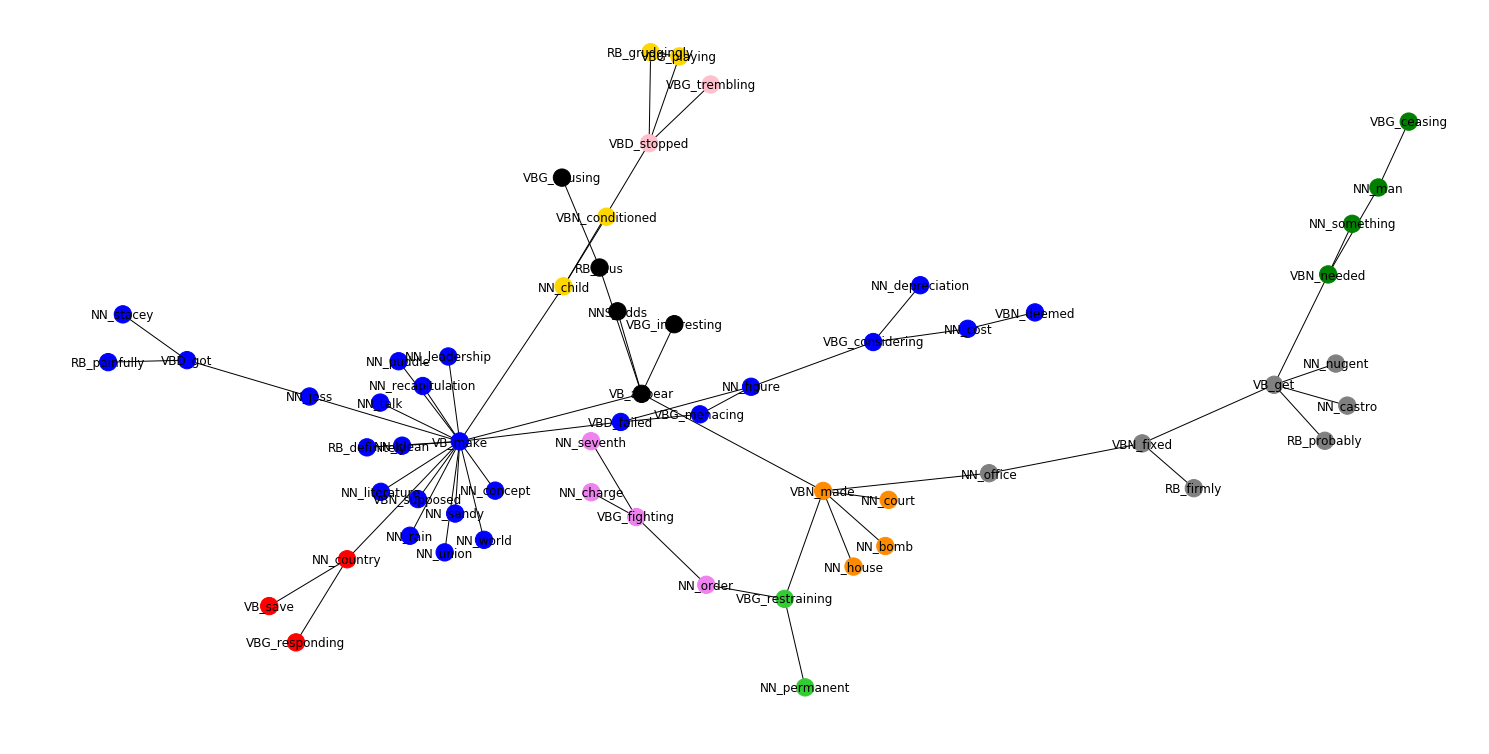

In [197]:
subset_color2 = subset_color + ["pink", "red", "blue", 'green', 'black', 'grey']
color = []

for v in G50_undir_lc.nodes():
    for index, words in enumerate(c):
        if v in words:
            color.append(subset_color[index])

plt.figure(figsize=(20, 10))
nx.draw(G50_undir_lc, nx.spring_layout(G50_undir_lc),
        node_color=color, with_labels=True)
plt.show()

In [198]:
community.modularity(G50_undir_lc, c)

0.5902983069067448

В принципе не очень понятно, как интерпретировать кластеры именно на моем графе, по задумке хотелось видеть семантически близкие глаголы в одном кластере (потому что у них было бы одно окружение), но примеров слишком мало, у глаголов не так много пересечений. Алгоритм asynchronous fluid communities выдал неплохие результаты (число кластеров было выбрано рандомно), модулярность выше, чем у алгоритма Гирван — Ньюмена. Как правило в отдельные кластеры выделились отдельные глаголы, которые встретились в рядом с другими глаголами, и их зависимые. Однако из-за того, кто кластера инициализируются рандомно, в разные итерации могут получиться совершенно разные разбивки, не всегда логичные. 

## SpectralClustering

In [199]:
from sklearn.cluster import SpectralClustering

In [304]:
M = nx.adjacency_matrix(G50_undir_lc)

In [319]:
for k in range(2, 15):
    clustering = SpectralClustering(n_clusters=k, 
                                assign_labels="discretize",
                                random_state=0).fit(M)
    
    clusters = defaultdict(list)
    for ind, v in enumerate(G50_undir_lc.nodes()):
        clust = clustering.labels_[ind]
        clusters[clust].append(v)
    
    mod = community.modularity(G50_undir_lc, clusters.values())
    print(k, mod)

2 -0.11300725611394855
3 -0.1420317119054024
4 -0.18126847621607142
5 -0.017065305025530202
6 -0.03735554958344483
7 -0.05374899220639591
8 -0.047836603063692654
9 0.018543402311206856
10 0.010346680999731371
11 -0.027411986025261924
12 -0.02217145928513831
13 -0.02351518409029821
14 -0.0693361999462509


In [320]:
clustering = SpectralClustering(n_clusters=9, 
                                assign_labels="discretize",
                                random_state=0).fit(M)

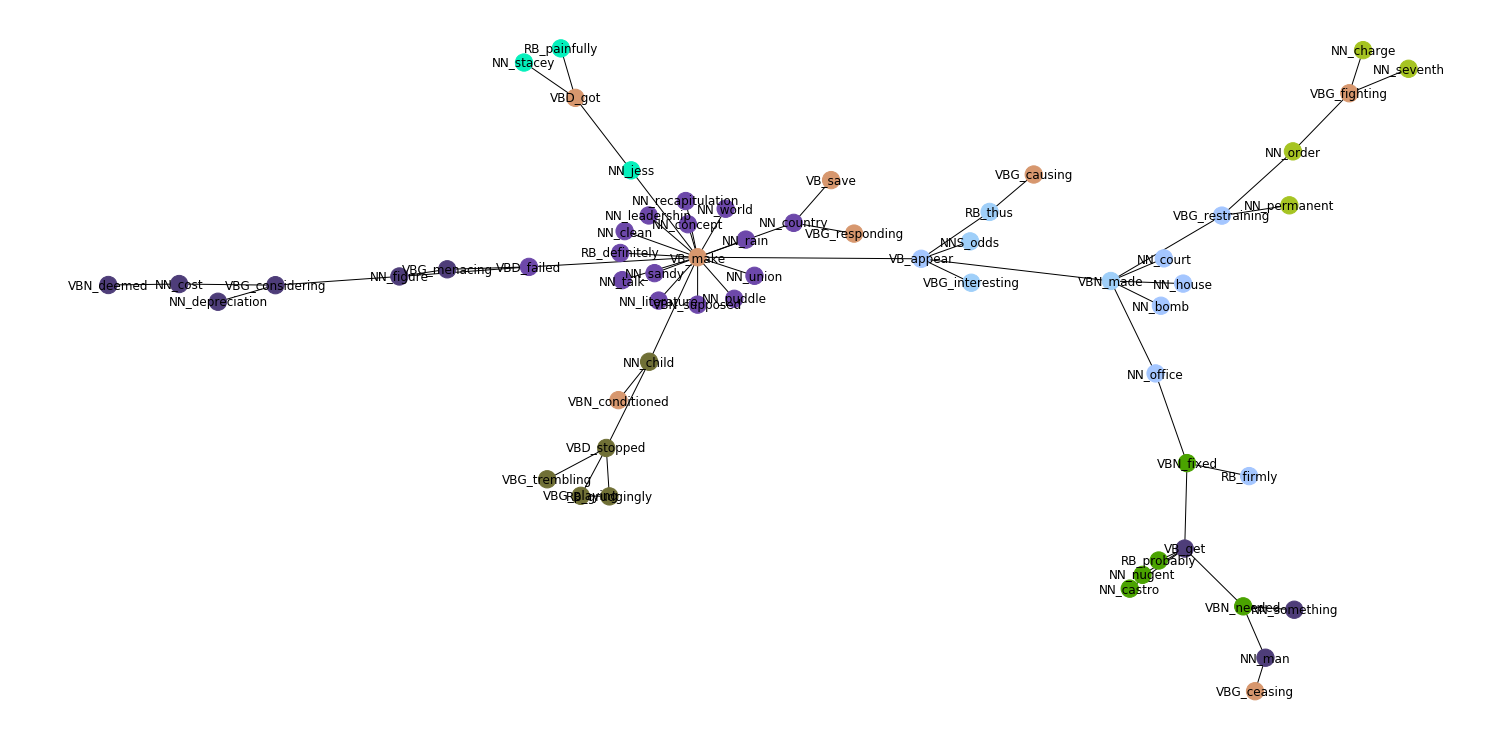

In [321]:
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(20)]
colors = [color[i] for i in clustering.labels_]

plt.figure(figsize=(20, 10))
nx.draw(G50_undir_lc, nx.spring_layout(G50_undir_lc),
        node_color=colors, with_labels=True)
plt.show()

Казалось бы, модулярность у спектральной кластеризации очень низкая, но если посмотреть на график, то можно увидеть инетерсные закономерности. В светло коричневый кластер попали только глаголы, в светло зеленый (правый верхний угол) только существительные, в светло фиолетовый только зависимые глагола make. В ярко зелено-синий только дополнения. Остальные классы +- рандомные.

# Каркас

In [ ]:

def create_lm_coocurance(sentences:List[List[str]], window_size: int = 2):
  """your code here
  :sentences
  :return: graph object (networkx object), pairs of words that you add to the graph"""
  graph = nx.Graph()
  pairs = []

  ...
  return graph, pairs

g, ps = create_lm_coocurance(brown.sents()[:5])     

 Взял пять предложений из корпуса и построил на них граф, окно - 2 (слева два слова и справа два). 

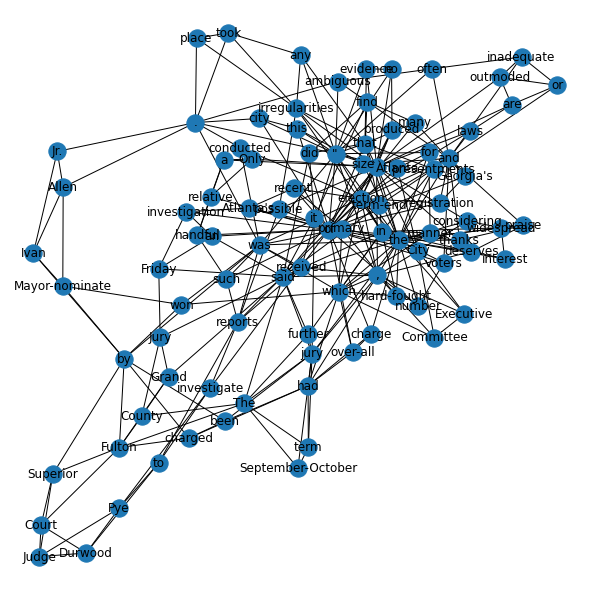

In [ ]:

# nx.spring_layout(g) создает позиции для вершин графа, именно там они и будут отрисованы
# больше layouts тут, порпобуйте - не пожалеете 
# https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
pos = nx.spring_layout(g)
plt.figure(figsize=(8, 8))
nx.draw(g, pos, with_labels=True)

## Descriptive analysis
Посмотрите сколько компонент, вершин, ребер. Если компонент несколько, не забывайте при анализе это учитывать. Плотность. Средняя степень вершины в графе. (2 points)

In [ ]:
 from networkx import density 
 "your code here and analysis also"

'your code here and analysis also'


*   Расcчитайте распределние степеней вершин внутри графа и постройте график (1 point)


*   Сделайте log-log scale для этих значений (1 point) 


*   Проверьте, если здесь powerlaw distribution (1 point) (то есть постройте апроксимирующую прямую) Дайте анализ результам у четом того, что ваш граф не является scale-free network 


тут есть пример - https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree_histogram.html 

In [ ]:
import matplotlib.pyplot as plt
#plt.hist(....)

Используйте ваши знания о центральностях и об их применимости к тем или иным типам графов. Рассчитайте их (возможно на сабграфе), сделайте отображение графа, на котором размер вершины будет зависить от показателя центральности, ну или цветом, как здесь: https://networkx.org/documentation/stable/auto_examples/drawing/plot_random_geometric_graph.html#sphx-glr-auto-examples-drawing-plot-random-geometric-graph-py
(3 points)

Не забудь проанализировать, ведь визуализация (иногда) ключ к пониманию

# Поиск сообществ

Посмотрел, какие слова кластеризовались, но тут кажется ничего вразумительного

In [ ]:
from networkx.algorithms.community.centrality import girvan_newman
comp = girvan_newman(g)
res = {i:words for i, words in enumerate(tuple(sorted(c) for c in next(comp)))}
# бинарное разбиение исходного графа на сообщетва
res

{0: ["''",
  ',',
  '.',
  'Allen',
  'Atlanta',
  "Atlanta's",
  'City',
  'Committee',
  'County',
  'Executive',
  'Friday',
  'Fulton',
  "Georgia's",
  'Grand',
  'Ivan',
  'Jr.',
  'Jury',
  'Mayor-nominate',
  'Only',
  'September-October',
  'Superior',
  'The',
  '``',
  'a',
  'ambiguous',
  'an',
  'and',
  'any',
  'are',
  'been',
  'by',
  'charge',
  'charged',
  'city',
  'conducted',
  'considering',
  'deserves',
  'did',
  'election',
  'evidence',
  'find',
  'for',
  'further',
  'had',
  'handful',
  'hard-fought',
  'in',
  'inadequate',
  'interest',
  'investigation',
  'irregularities',
  'it',
  'jury',
  'laws',
  'manner',
  'many',
  'no',
  'number',
  'of',
  'often',
  'or',
  'outmoded',
  'over-all',
  'place',
  'possible',
  'praise',
  'presentments',
  'primary',
  'produced',
  'received',
  'recent',
  'registration',
  'relative',
  'reports',
  'said',
  'size',
  'such',
  'term',
  'term-end',
  'thanks',
  'that',
  'the',
  'this',
  'took

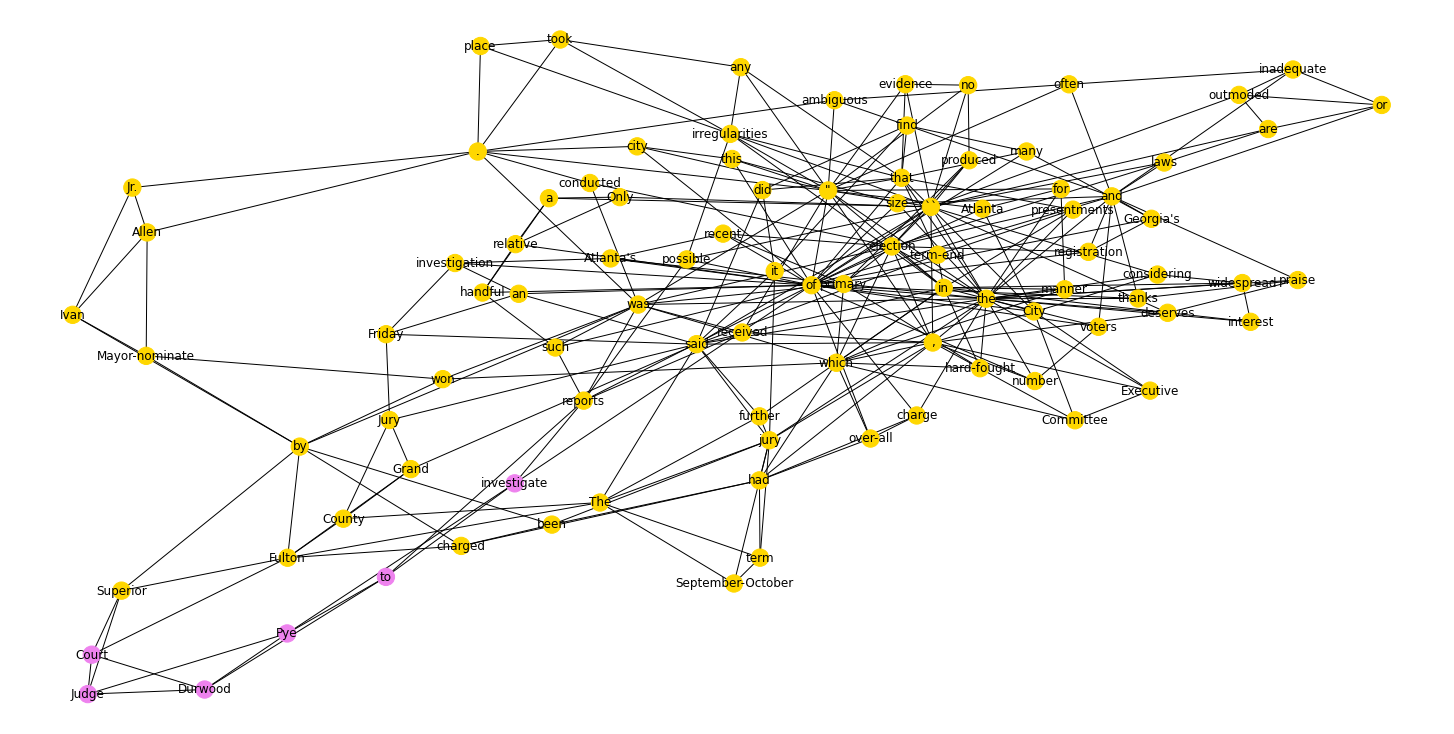

In [ ]:
subset_color = [
    "gold",
    "violet",
    "limegreen",
    "darkorange",
]
color = [ ]
for v in g.nodes():
  for i, words in res.items():
    if v in words:
      color.append(subset_color[i])
plt.figure(figsize=(20, 10))

nx.draw(g, pos, node_color=color, with_labels=True)
plt.show()

Ваша задача: применить методы поиска сообществ и попытаться интерпретировать выдачу (3 points)

In [ ]:
"your code here"

In [ ]:
import itertools
k = 2
# Посмотрим чуть глубже: 2 означает еще две итерации деления на сообщества  
for communities in itertools.islice(comp, k):
    print({indx: words for indx, words in enumerate(tuple(sorted(c) for c in communities))})  

{0: ['County', 'Friday', 'Fulton', 'Grand', 'Jury', 'September-October', 'Superior', 'The', 'an', 'been', 'by', 'charged', 'did', 'find', 'further', 'had', 'investigation', 'it', 'jury', 'said', 'term'], 1: ["''", ',', '.', 'Allen', 'Atlanta', "Atlanta's", 'City', 'Committee', 'Executive', "Georgia's", 'Ivan', 'Jr.', 'Mayor-nominate', 'Only', '``', 'a', 'ambiguous', 'and', 'any', 'are', 'charge', 'city', 'conducted', 'considering', 'deserves', 'election', 'evidence', 'for', 'handful', 'hard-fought', 'in', 'inadequate', 'interest', 'irregularities', 'laws', 'manner', 'many', 'no', 'number', 'of', 'often', 'or', 'outmoded', 'over-all', 'place', 'possible', 'praise', 'presentments', 'primary', 'produced', 'received', 'recent', 'registration', 'relative', 'reports', 'size', 'such', 'term-end', 'thanks', 'that', 'the', 'this', 'took', 'voters', 'was', 'which', 'widespread', 'won'], 2: ['Court', 'Durwood', 'Judge', 'Pye', 'investigate', 'to']}
{0: ['County', 'Friday', 'Fulton', 'Grand', 'Jur

Подарок для вас со стак оферфлоу: отрисовка графовой кластеризации с помощью дендрограммы (работает только с выходом из функции girvan_newman)

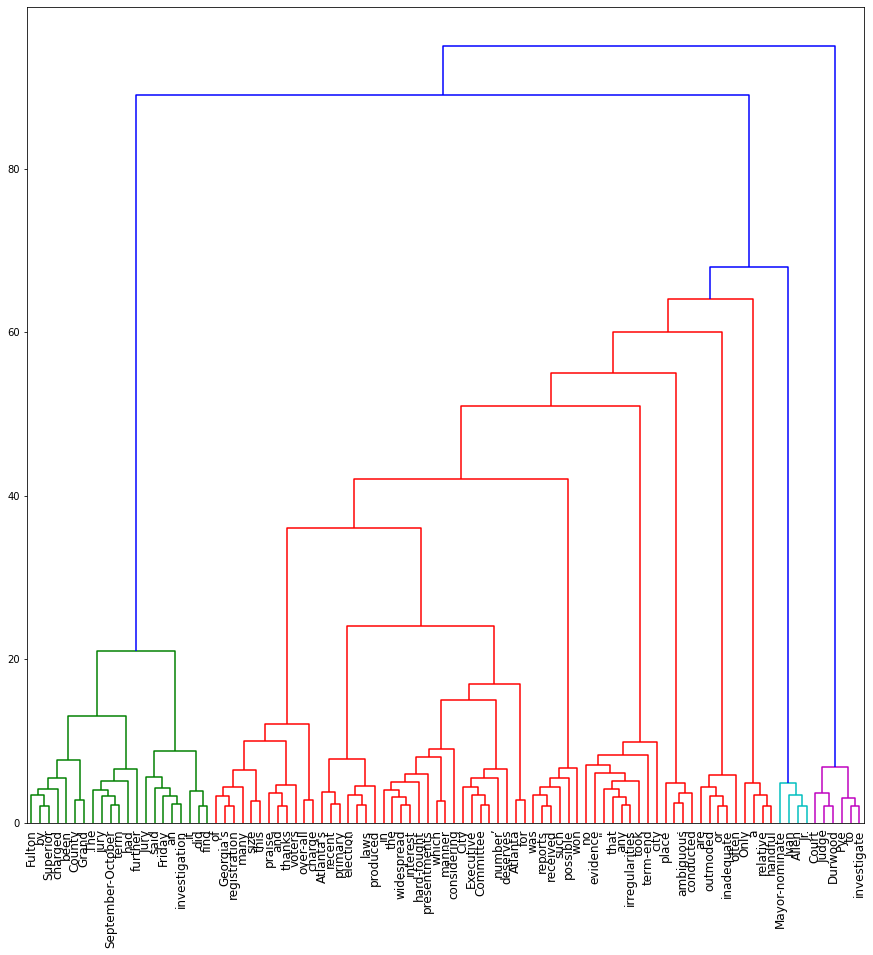

In [ ]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from networkx.algorithms.community.centrality import subset_rank_dict

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub, node_labels, subset_rank_dict):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

def plot_dendrogram(G, method_to_find_community = girvan_newman):
  communities = list(method_to_find_community(G))
  # building initial dict of node_id to each possible subset:
  node_id = 0
  init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
  for comm in communities:
      for subset in list(comm):
          if subset not in init_node2community_dict.values():
              node_id += 1
              init_node2community_dict[node_id] = subset

  # turning this dictionary to the desired format in @mdml's answer
  node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
  for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
      for node_id_parent, group in init_node2community_dict.items():
          if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
              node_id_to_children[node_id_parent].append(node_id1)
              node_id_to_children[node_id_parent].append(node_id2)

  # also recording node_labels dict for the correct label for dendrogram leaves
  node_labels = dict()
  for node_id, group in init_node2community_dict.items():
      if len(group) == 1:
          node_labels[node_id] = list(group)[0]
      else:
          node_labels[node_id] = ''

  # also needing a subset to rank dict to later know within all k-length merges which came first
  subset_rank_dict = dict()
  rank = 0
  for e in communities[::-1]:
      for p in list(e):
          if tuple(p) not in subset_rank_dict:
              subset_rank_dict[tuple(sorted(p))] = rank
              rank += 1
  subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

  # finally using @mdml's magic, slightly modified:
  G           = nx.DiGraph(node_id_to_children)
  nodes       = G.nodes()
  leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
  inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

  # Compute the size of each subtree
  subtree = dict( (n, [n]) for n in leaves )
  for u in inner_nodes:
      children = set()
      node_list = list(node_id_to_children[u])
      while len(node_list) > 0:
          v = node_list.pop(0)
          children.add( v )
          node_list += node_id_to_children[v]
      subtree[u] = sorted(children & leaves)

  inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

  # Construct the linkage matrix
  leaves = sorted(leaves)
  index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
  Z = []
  k = len(leaves)
  for i, n in enumerate(inner_nodes):
      children = node_id_to_children[n]
      x = children[0]
      for y in children[1:]:
          z = tuple(sorted(subtree[x] + subtree[y]))
          i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
          Z.append([i, j, get_merge_height(subtree[n], node_labels, subset_rank_dict), len(z)]) # <-- float is required by the dendrogram function
          index[z] = k
          subtree[z] = list(z)
          x = z
          k += 1

  plt.figure(figsize=(15, 15))
  dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
  plt.xticks(fontsize=12)
  plt.show()#

plot_dendrogram(g)

Можете применить при подготовке корпуса любые другие фишки, котоыре вы умеете использовать, как то снятие частеречной омонимии и прочее. Инициатива поощряется, без нее 10 не поставлю :)